## Section 2: Coding Questions

This section consists of coding questions. The total mark for this section is **85**. 
The task we are considering in this section is the text classification task. In this section, some code has been provided to help you get started. For each cell marked with **# Insert your code here**, these are placeholders where you **must** supply your own codes when instructed.
This section consists of 5 parts:
* Part 0: Downloading and preprocessing data. This part has been completed. No marks are allocated for this part.
* Part 1: Coding assessment on using Word2Vect to transform texts to vectors (20 marks).
* Part 2: Coding assessment on Text CNN for sequence modeling and neural embedding (10 marks).
* Part 3: Coding assessment on RNNs for sequence modeling and neural embedding (32 marks).
* Part 4: Coding assessment on Transformer for sequence modeling and neural embedding and the overall ranking (23 marks).

## <span style="color:#0b486b">Set random seeds</span>

We start with importing tensorflow and numpy and setting random seeds for TF and numpy. You can use any seeds you prefer.

In [300]:
import numpy as np
import tensorflow as tf

tf.random.set_seed(6789)
np.random.seed(6789)

In [301]:
x = tf.constant([1, 2, 3])
y = tf.constant([4, 5, 6])
tf.concat([x, y], axis = 0)

<tf.Tensor: shape=(6,), dtype=int32, numpy=array([1, 2, 3, 4, 5, 6])>

## <span style="color:#0b486b">Part 0: Download and preprocess the data</span>

<div style="text-align: right"><span style="color:red; font-weight:bold"><span></div>

The dataset we use for this assignment is a question classification dataset for which the training set consists of $5,500$ questions belonging to 6 coarse question categories including:
- abbreviation (ABBR), 
- entity (ENTY), 
- description (DESC), 
- human (HUM), 
- location (LOC) and 
- numeric (NUM).

In this assignment, we will utilize a subset of this dataset, containing $2,000$ questions for training and validation. We will use 80% of those 2000 questions for trainning and the rest for validation.


Preprocessing data is a crucial initial step in any machine learning or deep learning project. The *TextDataManager* class simplifies the process by providing functionalities to download and preprocess data specifically designed for the subsequent questions in this assignment. It is highly recommended to gain a comprehensive understanding of the class's functionality by **carefully reading** the content provided in the *TextDataManager.py* file before proceeding to answer the questions in Part 1.

In [302]:
from TextDataManager import SimpleTextDataset as DataManager

print("Loading data...")
DataManager.maybe_download("data", "train_2000.label", "http://cogcomp.org/Data/QA/QC/")

dm = DataManager(maxlen=100)
dm.read_data("data/", ["train_2000.label"])

Loading data...
Downloaded successfully train_2000.label

Sample questions and corresponding labels... 

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?']
['DESC', 'ENTY', 'DESC', 'ENTY', 'ABBR']


In [303]:
dm.manipulate_data()
dm.train_valid_split(train_ratio=0.8)

In [304]:
dm.train_numeral_data.shape

(1600, 100)

In [305]:
print(dm.train_str_questions)
print(dm.train_numeral_data.shape)
print(dm.valid_numeral_data.shape)
print(dm.train_numeral_labels.shape)

['manner how did serfdom develop in and then leave russia ?', 'cremat what films featured the character popeye doyle ?', "manner how can i find a list of celebrities ' real names ?", 'animal what fowl grabs the spotlight after the chinese year of the monkey ?', 'exp what is the full form of .com ?', 'ind what contemptible scoundrel stole the cork from my lunch ?', "gr what team did baseball 's st. louis browns become ?", 'title what is the oldest profession ?', 'def what are liver enzymes ?', 'ind name the scar-faced bounty hunter of the old west .', 'date when was ozzy osbourne born ?', 'reason why do heavier objects travel downhill faster ?', 'ind who was the pride of the yankees ?', 'ind who killed gandhi ?', 'event what is considered the costliest disaster the insurance industry has ever faced ?', 'state what sprawling u.s. state boasts the most airports ?', 'desc what did the only repealed amendment to the u.s. constitution deal with ?', 'count how many jews were executed in conce

You now have a data manager, named *dm* containing the training and validiation sets in both text and numeric forms. Your task is to play around and read this code to figure out the meanings of some important attributes that will be used in the next parts.

## <span style="color:#0b486b">Part 1: Using Word2Vect to transform texts to vectors </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 20 marks]<span></div>

In this part, you will be assessed on how to use a pretrained Word2Vect model for realizing a machine learning task. Basically, you will use this pretrained Word2Vect to transform the questions in the above dataset stored in the *data manager object dm* to numeric form for training a classifier using Logistic Regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [306]:
import gensim.downloader as api
from gensim.models import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn import metrics
import numpy as np

#### <span style="color:red">**Question 1.1**</span> 
**Write code to download the pretrained model *glove-wiki-gigaword-100*. Note that this model transforms a word in its dictionary to a $100$ dimensional vector.**

**Write code for the function *get_word_vector(word, model)* used to transform a word to a vector using the pretrained Word2Vect model *model*. Note that for a word not in the vocabulary of our *word2vect*, you need to return a vector $0$ with 100 dimensions.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [307]:
word2vect = api.load("glove-wiki-gigaword-100")

In [308]:
def get_word_vector(word, model):
    try:
        vector = model.get_vector(word)
    except:  # word not in the vocabulary
        vector = np.zeros((100,))
    return vector

#### <span style="color:red">**Question 1.2**</span> 

**Write the code for the function `get_sentence_vector(sentence, important_score=None, model= None)`. Note that this function will transform a sentence to a 100-dimensional vector using the pretrained model *model*. In addition, the list *important_score* which has the same length as the *sentence* specifies the important scores of the words in the sentence. In your code, you first need to apply *softmax* function over *important_score* to obtain the important weight *important_weight* which forms a probability over the words of the sentence. Furthermore, the final vector of the sentence will be weighted sum of the individual vectors for words and the weights in *important_weight*.**
- $important\_weight = softmax(important\_score)$.
- $final\_vector= important\_weight[1]\times v[1] + important\_weight[2]\times v[2] + ...+ important\_weight[T]\times v[T]$ where $T$ is the length of the sentence and $v[i]$ is the vector representation of the $i-th$  word in this sentence.

**Note that if `important_score=None` is set by default, your function should return the average of all representation vectors corresponding to set `important_score=[1,1,...,1]`.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [309]:
def softmax(val, denom):
    return np.exp(val) / denom

In [310]:
def get_sentence_vector(sentence, important_score=None, model=None):
    sentence = sentence.split(" ")

    important_score = important_score or np.ones((len(sentence),))

    word_vectors = [get_word_vector(word, model) for word in sentence]

    denom = sum([np.exp(val) for val in important_score])
    impt_weight = [softmax(val, denom) for val in important_score]

    calculated_vector = [
        np.array([sm * val for val in vect])
        for sm, vect in zip(impt_weight, word_vectors)
    ]

    final_vector = np.zeros((100,))
    for vect in calculated_vector:
        final_vector = final_vector + vect

    return final_vector

#### <span style="color:red">**Question 1.3**</span> 

**Write code to transform questions in *dm.train_str_questions* and *dm.valid_str_questions* to feature vectors. Note that after running the following cells, you must have $X\_train$ and $X\_valid$ which are two numpy arrays of the feature vectors and $y\_train$ and $y\_valid$ which are two arrays of numeric labels (Hint: *dm.train_numeral_labels* and *dm.valid_numeral_labels*). You can add more lines to the following cells if necessary. In addition, you should decide the *important_score* by yourself. For example, you might reckon that the 1st score is 1, the 2nd score is decayed by 0.9, the 3rd is decayed by 0.9, and so on.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div> 

In [311]:
print("Transform training set to feature vectors...")
X_train = np.array(
    [
        get_sentence_vector(sentence, model=word2vect)
        for sentence in dm.train_str_questions
    ]
)
y_train = np.array(dm.train_numeral_labels)

Transform training set to feature vectors...


In [312]:
print("Transform validation set to feature vectors...")
X_valid = np.array(
    [
        get_sentence_vector(sentence, model=word2vect)
        for sentence in dm.valid_str_questions
    ]
)
y_valid = np.array(dm.valid_numeral_labels)

Transform validation set to feature vectors...


#### <span style="color:red">**Question 1.4**</span> 

**It is now to use *MinMaxScaler(feature_range=(-1,1))* in scikit-learn to scale both training and validation sets to the range $(-1,1)$.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div> 

In [313]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X_train)
X_train = scaler.fit_transform(X_train)
scaler.fit(X_valid)
X_valid = scaler.fit_transform(X_valid)

#### <span style="color:red">**Question 1.5**</span>
**Train a Logistic Regression model on the training set and then evaluate on the validation set.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [314]:
from sklearn.linear_model import LogisticRegression

logistic = LogisticRegression(
    penalty="l1",
    dual=False,
    tol=0.0001,
    C=1.0,
    fit_intercept=True,
    intercept_scaling=1,
    class_weight=None,
    random_state=None,
    solver="liblinear",
    max_iter=100,
    multi_class="ovr",
    verbose=0,
    warm_start=False,
    n_jobs=1,
)

In [315]:
# Insert your code for training here
train_model = logistic.fit(X_train, y_train)

In [316]:
# Insert your code for validation here
pred_results = train_model.decision_function(X_valid)

In [317]:
pred_labels = [np.argmax(pred_results[i]) for i in range(len(pred_results))]
target_names = ["Category  " + str(i) for i in range(len(np.unique(pred_labels)))]
print(metrics.classification_report(pred_labels, y_valid, target_names=target_names))

              precision    recall  f1-score   support

 Category  0       0.67      1.00      0.80         4
 Category  1       0.82      0.88      0.85        81
 Category  2       0.79      0.62      0.69       126
 Category  3       0.59      1.00      0.74        50
 Category  4       0.88      0.68      0.77        78
 Category  5       0.83      0.85      0.84        61

    accuracy                           0.77       400
   macro avg       0.76      0.84      0.78       400
weighted avg       0.79      0.77      0.77       400



### **Embedding visualization**

**As you know, the embedding matrix is a collection of embedding vectors, each is for one word. In this part, you will base on the cosine similarity of the embedding vectors for the words to find the top-k most relevant words for a given word.**

**Good embeddings should have words close in meaning near each other by some similarity metrics. The similarity metric we'll use is the `cosine` similarity, which is defined for two vector $\mathbf{u}$ and $\mathbf{v}$ as $\cos(\mathbf{u}, \mathbf{v})=\frac{\mathbf{u} \cdot \mathbf{v}}{\left\Vert{\mathbf{u}}\right\Vert\left\Vert{\mathbf{v}}\right\Vert}$ where $\cdot$ means dot product and $\left\Vert\cdot\right\Vert$ means the $L^2$ norm.**

In [318]:
""" Checks the cosine similarity between 2 np arrays (or vectors)
Inputs:
    u - The first input vector
    v - The second input vector
Output:
    The cosine similarity of the 2 input vectors
"""


def cosine_similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [319]:
cosine_similarity(np.array([1, 2, 3]), np.array([4, 5, 6]))

0.9746318461970762

#### <span style="color:red">**Question 1.6** </span> 

**Write code for the `function find_most_similar(word=None, k=5, model=None)` which returns a list of the top-`k` most similar words (in descending order) for a given word. This similarity is based on the cosine similarity of embedding vectors obtained from the pretrained model `glove-wiki-gigaword-100` (see Question 1.1). The parameter `include_cur_word` specifies whether the given word should be included in the returned output or not. This means that if `include_cur_word=True`, the function will return `k+1` words.** 

<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [320]:
def find_most_similar(word=None, k=5, model=None, include_cur_word=False):
    try:
        # Insert your code here
        word_vec = get_word_vector(word, model)

        if not sum(word_vec):
            raise Exception("Word is not in the dictionary")

        sim_words = model.similar_by_word(word, k)

        if include_cur_word:
            sim_words.insert(0, (word, 1))

        print(sim_words)

        return sim_words
    except:  # Word not in the vocabulary
        print("Word is not in the dictionary!")

In [321]:
find_most_similar(word="computer", k=10, model=word2vect, include_cur_word=True)

[('computer', 1), ('computers', 0.8751984238624573), ('software', 0.8373122215270996), ('technology', 0.7642159461975098), ('pc', 0.7366448640823364), ('hardware', 0.7290390729904175), ('internet', 0.7286775708198547), ('desktop', 0.7234441637992859), ('electronic', 0.7221828699111938), ('systems', 0.7197922468185425), ('computing', 0.7141730785369873)]


[('computer', 1),
 ('computers', 0.8751984238624573),
 ('software', 0.8373122215270996),
 ('technology', 0.7642159461975098),
 ('pc', 0.7366448640823364),
 ('hardware', 0.7290390729904175),
 ('internet', 0.7286775708198547),
 ('desktop', 0.7234441637992859),
 ('electronic', 0.7221828699111938),
 ('systems', 0.7197922468185425),
 ('computing', 0.7141730785369873)]

Here is the example of the above function. You can check your implementation using the provided `result`. As you can observe, the `result` makes sense which demonstrates that the embedding matrix is meaningful.

In [322]:
result = [
    "computer",
    "computers",
    "software",
    "technology",
    "pc",
    "hardware",
    "internet",
    "desktop",
    "electronic",
    "systems",
    "computing",
]
output = [
    word
    for (word, _) in find_most_similar(
        word="computer", k=10, model=word2vect, include_cur_word=True
    )
]
if output == result:
    print("Your implementation is correct.")
else:
    print("Your implementation is not correct.")

[('computer', 1), ('computers', 0.8751984238624573), ('software', 0.8373122215270996), ('technology', 0.7642159461975098), ('pc', 0.7366448640823364), ('hardware', 0.7290390729904175), ('internet', 0.7286775708198547), ('desktop', 0.7234441637992859), ('electronic', 0.7221828699111938), ('systems', 0.7197922468185425), ('computing', 0.7141730785369873)]
Your implementation is correct.


#### <span style="color:red">**Question 1.7** </span> 
**Implement the `plot2D_with_groups(word_list, model, k=10)` function to visualize groups of similar words in 2D space. The `word_list` parameter is a list of words, and for each word in the `word_list`, find its top-`k` most similar words (which forms a group) using the `find_most_similar` function. Use tSNE to project embedding vectors into 2D space and plot groups with different colors. You can use the colormaps from `matplotlib`, i.e., `cmap = plt.get_cmap('brg')`.**

**The figure bellow is the output obtained by running `plot2D_with_groups` using the input `word_list=['an', 'introduction', 'to', 'deep', 'learning']`. Note that the words within the `word_list` are also visualized (in black) as shown in the figure.**

<img src="./images/2Dtsne.png" align="center" width=600/>

**As you can observe, words within each group tend to be closer to each other, while words from different groups are more distant.**

<div style="text-align: right"><span style="color:red">[5 marks]</span></div>

In [323]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(perplexity=5, n_components=2, init="pca", n_iter=5000)

"""
Function to plot a list of words (and their top-k most similar words)

Inputs:
    word_list - The list of words to be plotted
    k         - The number of similar words each word in the word list should have
    model     - The model to get the embeddings from
Outcome:
    All words in word_list and their top-k most similar words plotted 
     where each word (and their similar words) are clustered together with their own colour
    Every word from word_list will be coloured black and are bolded
"""
def plot2D_with_groups(word_list=None, k=10, model=None):
    plt.figure(figsize=(20, 20))
    word_count = len(word_list) * (k + 1)

    # Getting every word and their similar words.
    all_words = np.array(
        [
            [
                sim_word
                for (sim_word, _) in find_most_similar(
                    word=word, k=k, model=model, include_cur_word=True
                )
            ]
            for word in word_list
        ]
    ).reshape((word_count))

    # Getting the embeddings for every word
    #  then, fit it to their coordinates
    all_words_embeddings = np.array(
        [get_word_vector(word, model) for word in all_words]
    )
    coords = tsne.fit_transform(all_words_embeddings)

    # Plotting the words one by one
    for i, label in enumerate(all_words):
        x, y = coords[i]
        c = [
                float(i) / float(word_count),
                0.0,
                float(word_count - i) / float(word_count),
            ]
        plt.scatter(x, y, c=c)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords="offset points",
            ha="left",
            va="bottom",
            color=c
            if i % (k + 1)
            else [0, 0, 0],
            weight=0 if i % (k + 1) else "bold",
        )

[('an', 1), ('another', 0.8373265266418457), ('a', 0.8172469139099121), ('as', 0.8146691918373108), ('one', 0.7935026288032532), ('this', 0.7922350764274597), ('the', 0.7917823791503906), ('was', 0.7648624181747437), ('first', 0.7629119753837585), ('it', 0.7614699602127075), ('with', 0.7582710385322571)]
[('introduction', 1), ('introduced', 0.7444450855255127), ('introducing', 0.7438881397247314), ('creation', 0.7046433687210083), ('concept', 0.6862993240356445), ('example', 0.6572403311729431), ('changes', 0.6478949189186096), ('version', 0.6454115509986877), ('addition', 0.6424310207366943), ('subsequent', 0.6390542984008789), ('translation', 0.63484126329422)]
[('to', 1), ('would', 0.8726492524147034), ('take', 0.8696873784065247), ('help', 0.8600242137908936), ('make', 0.8553706407546997), ('could', 0.8412613272666931), ('able', 0.8320693969726562), ('will', 0.8313010931015015), ('not', 0.8197757601737976), ('come', 0.8090698719024658), ('give', 0.8083649277687073)]
[('deep', 1), (

C:\Users\User\AppData\Local\Temp\ipykernel_532\892779179.py:50: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, c=c)


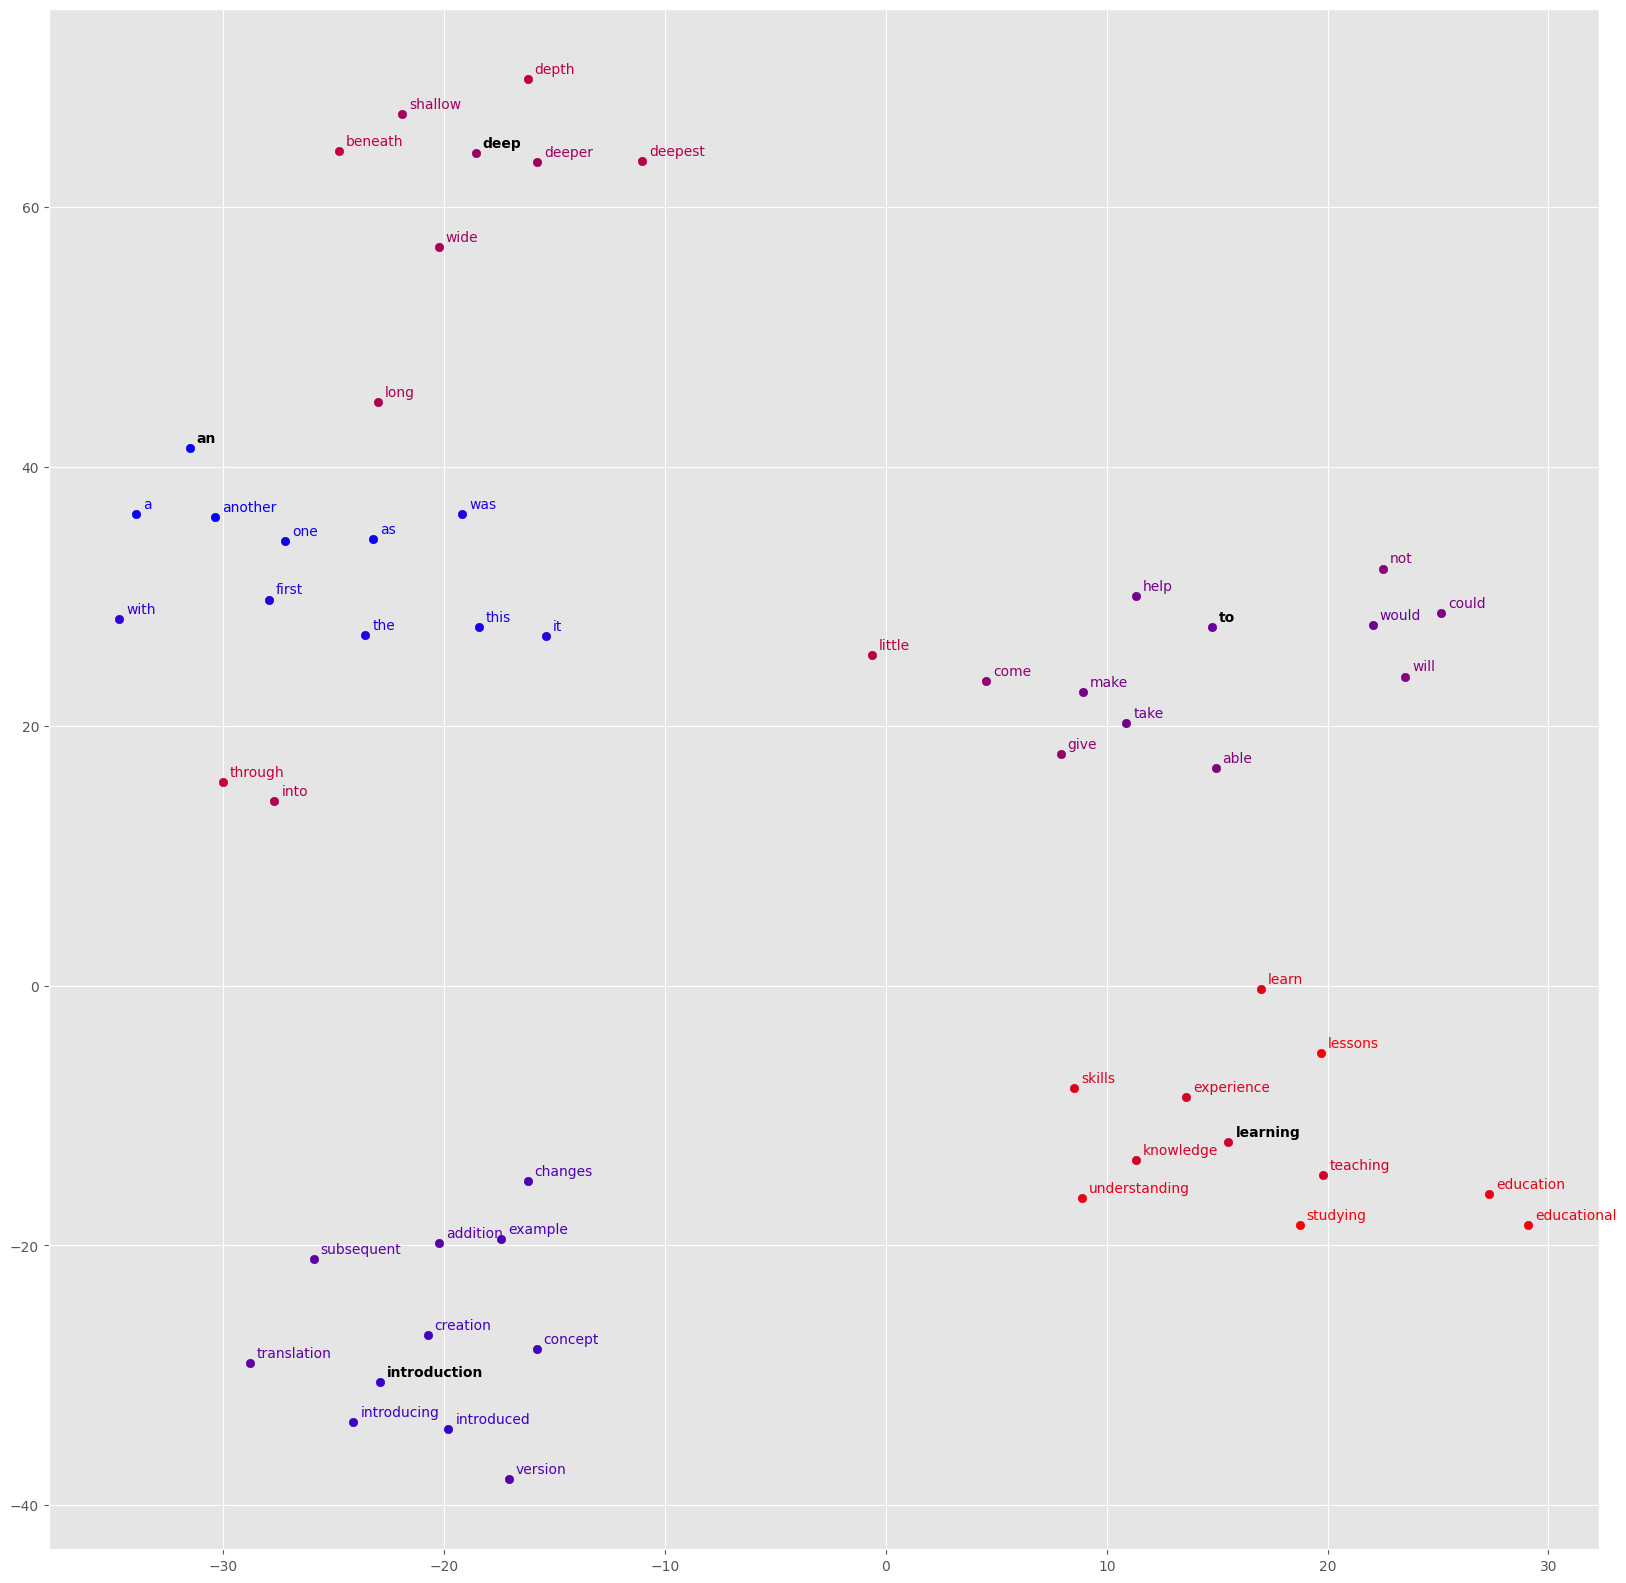

In [324]:
word_list = ["an", "introduction", "to", "deep", "learning"]
plot2D_with_groups(word_list=word_list, k=10, model=word2vect)

## <span style="color:#0b486b">Part 2: Text CNN for sequence modeling and neural embedding </span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 10 marks]<span></div>

#### <span style="color:red">**Question 2.1**</span> 

**In what follows, you are required to complete the code for Text CNN for sentence classification. The paper of Text CNN can be found at this [link](https://www.aclweb.org/anthology/D14-1181.pdf). Here is the description of the Text CNN that you need to construct.**
- There are three attributes (properties or instance variables): *embed_size, state_size, data_manager*.
  - `embed_size`: the dimension of the vector space for which the words are embedded to using the embedding matrix.
  - `state_size`: the number of filters used in *Conv1D* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv1D)).
  - `data_manager`: the data manager to store information of the dataset.
- The detail of the computational process is as follows:
  - Given input $x$, we embed $x$ using the embedding matrix to obtain an $3D$ tensor $[batch\_size \times maxlen \times embed\_size]$ as $h$.
  - We feed $h$ to three *Conv1D* layers, each of which has $state\_size$ filters, padding=same, activation= relu, and $kernel\_size= 3, 5, 7$ respectively to obtain $h1, h2, h3$. Note that each $h1, h2, h3$ is a 3D tensor with the shape $[batch\_size \times output\_size \times state\_size]$.
  - We then apply *GlobalMaxPool1D()* (reference [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalMaxPool1D)) over $h1, h2, h3$ to obtain 2D tensors stored in $h1, h2, h3$ again.
  - We then concatenate three 2D tensors $h1, h2, h3$ to obtain $h$. Note that you need to specify the axis to concatenate.
  - We finally build up one dense layer on the top of $h$ for classification.
  
  <div style="text-align: right"><span style="color:red">[8 marks]</span></div>
  

In [325]:
class TextCNN:
    def __init__(self, embed_size= 128, state_size=16, data_manager=None):
        self.data_manager = data_manager
        self.embed_size = embed_size
        self.state_size = state_size
    
    def build(self):
        glob_max_pool = tf.keras.layers.GlobalMaxPooling1D()

        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.data_manager.vocab_size +1, self.embed_size, mask_zero=True)(x)

        h1 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size = 3, padding = 'same', activation='relu')(h)
        h2 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size = 3, padding = 'same', activation='relu')(h)
        h3 = tf.keras.layers.Conv1D(filters=self.state_size, kernel_size = 3, padding = 'same', activation='relu')(h)
        h1 = glob_max_pool(h1)
        h2 = glob_max_pool(h2)
        h3 = glob_max_pool(h3)
        h = tf.keras.layers.Concatenate(axis = 1)([h1, h2, h3])
        
        h = tf.keras.layers.Dense(self.data_manager.num_classes, activation='softmax')(h)
        self.model = tf.keras.Model(inputs=x, outputs=h) 
    
    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)
    
    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)
    
    def evaluate(self, *args, **kwargs):
        self.model.evaluate(*args, **kwargs)


#### <span style="color:red">**Question 2.2**</span> 
**Here is the code to test TextCNN above. You can observe that TextCNN outperforms the traditional approach Word2Vect with Logistic Regression for this task. The reason is that TextCNN enables us to automatically learn the feature that fits to the task. This makes deep learning different from hand-crafted feature approaches. Complete the code to test the model. Note that when compiling the model, you can use the Adam optimizer.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [326]:
text_cnn = TextCNN(data_manager=dm)
text_cnn.build()

loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
text_cnn.compile_model(optimizer='adam', loss = loss_fn)
text_cnn.fit(dm.train_numeral_data, dm.train_numeral_labels, epochs=20)


Epoch 1/20
50/50 [==============================] - 6s 85ms/step - loss: 1.5777
Epoch 2/20
50/50 [==============================] - 4s 84ms/step - loss: 0.7950
Epoch 3/20
50/50 [==============================] - 4s 79ms/step - loss: 0.2400
Epoch 4/20
50/50 [==============================] - 4s 82ms/step - loss: 0.1083
Epoch 5/20
50/50 [==============================] - 4s 82ms/step - loss: 0.0615
Epoch 6/20
50/50 [==============================] - 4s 82ms/step - loss: 0.0375
Epoch 7/20
50/50 [==============================] - 4s 83ms/step - loss: 0.0231
Epoch 8/20
50/50 [==============================] - 4s 84ms/step - loss: 0.0154
Epoch 9/20
50/50 [==============================] - 4s 79ms/step - loss: 0.0101
Epoch 10/20
50/50 [==============================] - 4s 82ms/step - loss: 0.0072
Epoch 11/20
50/50 [==============================] - 4s 80ms/step - loss: 0.0053
Epoch 12/20
50/50 [==============================] - 4s 79ms/step - loss: 0.0040
Epoch 13/20
50/50 [==================

## <span style="color:#0b486b">Part 3: RNN-based models for sequence modeling and neural embedding</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 32 marks]<span></div>

### <span style="color:#0b486b">3.1. RNNs with different cell types</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.1.1**</span> 
**In this part, you need to construct a vanilla RNN to learn from the dataset of interest. Basically, you are required to construct the class RNN with the following requirements:**
- Attribute `data_manager (self.data_manager)`: specifies the data manager used to store data for the model.
- Attribute `cell_type (self.cell_type)`: can take one of the three values, i.e., `simple_rnn`, `gru`, or `lstm` which specifies the memory cells formed a hidden layer.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Note that when declaring an embedding layer for the network, you need to set *mask_zero=True* so that the padding zeros in the sentences will be masked and ignored. This helps to have variable length RNNs. For more detail, you can refer to this [link](https://www.tensorflow.org/guide/keras/masking_and_padding).**

<div style="text-align: right"><span style="color:red">[7 marks]</span></div>

In [327]:
class BaseRNN:
    def __init__(
        self, cell_type="gru", embed_size=128, state_sizes=[128, 64], data_manager=None
    ):
        self.cell_type = cell_type
        self.state_sizes = state_sizes
        self.embed_size = embed_size
        self.data_manager = data_manager
        self.vocab_size = self.data_manager.vocab_size + 1

    # return the corresponding memory cell
    @staticmethod
    def get_layer(
        cell_type="gru",
        state_size=128,
        return_sequences=False,
        activation="tanh",
        return_state=False,
    ):
        if cell_type == "gru":
            return tf.keras.layers.GRU(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
            )
        elif cell_type == "lstm":
            return tf.keras.layers.LSTM(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
            )
        else:  # cell_type == 'simple_rnn'
            return tf.keras.layers.SimpleRNN(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
            )

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        h = tf.keras.layers.Embedding(self.vocab_size, self.embed_size, mask_zero=True)(
            x
        )
        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = BaseRNN.get_layer(
                cell_type=self.cell_type,
                state_size=self.state_sizes[i],
                return_sequences=(i != num_layers - 1),
            )(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation="softmax")(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)

#### <span style="color:red">**Question 3.1.2**</span> 
**Run with simple RNN ('simple_rnn') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [328]:
base_rnn = BaseRNN(cell_type='simple_rnn', embed_size=128, state_sizes=[64, 128], data_manager=dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 20s 630ms/step - loss: 0.8724 - accuracy: 0.7025 - val_loss: 0.2847 - val_accuracy: 0.9225
Epoch 2/20
25/25 [==============================] - 14s 551ms/step - loss: 0.1819 - accuracy: 0.9513 - val_loss: 0.4999 - val_accuracy: 0.8350
Epoch 3/20
25/25 [==============================] - 14s 562ms/step - loss: 0.0932 - accuracy: 0.9712 - val_loss: 0.1577 - val_accuracy: 0.9525
Epoch 4/20
25/25 [==============================] - 14s 549ms/step - loss: 0.0582 - accuracy: 0.9856 - val_loss: 0.1275 - val_accuracy: 0.9600
Epoch 5/20
25/25 [==============================] - 13s 520ms/step - loss: 0.0193 - accuracy: 0.9962 - val_loss: 0.1709 - val_accuracy: 0.9550
Epoch 6/20
25/25 [==============================] - 15s 589ms/step - loss: 0.0406 - accuracy: 0.9887 - val_loss: 0.1278 - val_accuracy: 0.9600
Epoch 7/20
25/25 [==============================] - 14s 546ms/step - loss: 0.0190 - accuracy: 0.9944 - val_loss: 0.1377 - val_accuracy: 0.9625

#### <span style="color:red">**Question 3.1.3**</span> 
**Run with GRU ('gru') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [329]:
base_rnn = BaseRNN(cell_type='gru', embed_size=128, state_sizes=[64, 128], data_manager=dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 37s 1s/step - loss: 1.5299 - accuracy: 0.3494 - val_loss: 1.0469 - val_accuracy: 0.6000
Epoch 2/20
25/25 [==============================] - 23s 935ms/step - loss: 0.4922 - accuracy: 0.8438 - val_loss: 0.2608 - val_accuracy: 0.9225
Epoch 3/20
25/25 [==============================] - 23s 925ms/step - loss: 0.1262 - accuracy: 0.9650 - val_loss: 0.1965 - val_accuracy: 0.9375
Epoch 4/20
25/25 [==============================] - 23s 937ms/step - loss: 0.0691 - accuracy: 0.9794 - val_loss: 0.3135 - val_accuracy: 0.9300
Epoch 5/20
25/25 [==============================] - 23s 928ms/step - loss: 0.0357 - accuracy: 0.9900 - val_loss: 0.1363 - val_accuracy: 0.9650
Epoch 6/20
25/25 [==============================] - 24s 947ms/step - loss: 0.0113 - accuracy: 0.9962 - val_loss: 0.1766 - val_accuracy: 0.9525
Epoch 7/20
25/25 [==============================] - 23s 931ms/step - loss: 0.0145 - accuracy: 0.9950 - val_loss: 0.1702 - val_accuracy: 0.9650
Ep

#### <span style="color:red">**Question 3.1.4**</span> 
**Run with LSTM ('lstm') cell with $embed\_size= 128, state\_sizes= [64, 128], data\_manager= dm$.**

<div style="text-align: right"><span style="color:red">[1 mark]</span></div>

In [330]:
base_rnn = BaseRNN(cell_type='lstm', embed_size=128, state_sizes=[64, 128], data_manager=dm)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
base_rnn.fit(dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64))

Epoch 1/20
25/25 [==============================] - 47s 1s/step - loss: 1.2875 - accuracy: 0.5244 - val_loss: 0.6956 - val_accuracy: 0.7850
Epoch 2/20
25/25 [==============================] - 32s 1s/step - loss: 0.4939 - accuracy: 0.8481 - val_loss: 0.2961 - val_accuracy: 0.9275
Epoch 3/20
25/25 [==============================] - 32s 1s/step - loss: 0.2106 - accuracy: 0.9450 - val_loss: 0.2135 - val_accuracy: 0.9350
Epoch 4/20
25/25 [==============================] - 33s 1s/step - loss: 0.0938 - accuracy: 0.9781 - val_loss: 0.1752 - val_accuracy: 0.9550
Epoch 5/20
25/25 [==============================] - 33s 1s/step - loss: 0.0702 - accuracy: 0.9837 - val_loss: 0.1408 - val_accuracy: 0.9600
Epoch 6/20
25/25 [==============================] - 33s 1s/step - loss: 0.0497 - accuracy: 0.9869 - val_loss: 0.1427 - val_accuracy: 0.9575
Epoch 7/20
25/25 [==============================] - 32s 1s/step - loss: 0.0217 - accuracy: 0.9962 - val_loss: 0.1516 - val_accuracy: 0.9575
Epoch 8/20
25/25 [==

#### <span style="color:red">**Question 3.1.5**</span> 
**Write code to conduct experiments to compare the accuracies of RNNs with the three different cell types using 2 different lists of `state_sizes` (while the other hyperparameters are fixed). Specifically, for each `state_sizes = [...]`, you should report the accuracies of RNNs with simple RNN ('simple_rnn') cell, GRU ('gru') cell, and LSTM ('lstm') cell. Give your comments on the results.**
<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [331]:
def get_loss_acc(cell_type, state_sizes):
    base_rnn = BaseRNN(
        cell_type=cell_type, embed_size=128, state_sizes=state_sizes, data_manager=dm
    )
    base_rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    base_rnn.compile_model(
        optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    base_rnn.fit(
        dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
    )
    return base_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)


loss_acc_params = [
    get_loss_acc(ct, ss) + [ct, ss]
    for ct in ["simple_rnn", "gru", "lstm"]
    for ss in [[64, 128], [128, 64]]
]

Epoch 1/20
25/25 [==============================] - 5s 175ms/step - loss: 0.8479 - accuracy: 0.7100 - val_loss: 0.3263 - val_accuracy: 0.9225
Epoch 2/20
25/25 [==============================] - 4s 167ms/step - loss: 0.1748 - accuracy: 0.9581 - val_loss: 0.2498 - val_accuracy: 0.9325
Epoch 3/20
25/25 [==============================] - 4s 166ms/step - loss: 0.1125 - accuracy: 0.9681 - val_loss: 0.1564 - val_accuracy: 0.9550
Epoch 4/20
25/25 [==============================] - 4s 167ms/step - loss: 0.0324 - accuracy: 0.9919 - val_loss: 0.1372 - val_accuracy: 0.9650
Epoch 5/20
25/25 [==============================] - 5s 185ms/step - loss: 0.0225 - accuracy: 0.9956 - val_loss: 0.1291 - val_accuracy: 0.9625
Epoch 6/20
25/25 [==============================] - 5s 186ms/step - loss: 0.0417 - accuracy: 0.9887 - val_loss: 0.1280 - val_accuracy: 0.9600
Epoch 7/20
25/25 [==============================] - 5s 193ms/step - loss: 0.0060 - accuracy: 0.9994 - val_loss: 0.1169 - val_accuracy: 0.9675
Epoch 

In [332]:
print(
    "".join(
        [
            "Results:\n",
            "\n".join(
                [
                    "Cell Type: {0}{4}  |  State Sizes: {1}   -->   Loss = {2:1.3f}  |  Accuracy = {3:1.3f}".format(
                        ct, ss, loss, acc, " " * (10 - len(ct))
                    )
                    for loss, acc, ct, ss in loss_acc_params
                ]
            ),
        ]
    )
)

Results:
Cell Type: simple_rnn  |  State Sizes: [64, 128]   -->   Loss = 0.370  |  Accuracy = 0.970
Cell Type: simple_rnn  |  State Sizes: [128, 64]   -->   Loss = 0.268  |  Accuracy = 0.962
Cell Type: gru         |  State Sizes: [64, 128]   -->   Loss = 0.518  |  Accuracy = 0.957
Cell Type: gru         |  State Sizes: [128, 64]   -->   Loss = 0.314  |  Accuracy = 0.970
Cell Type: lstm        |  State Sizes: [64, 128]   -->   Loss = 0.276  |  Accuracy = 0.967
Cell Type: lstm        |  State Sizes: [128, 64]   -->   Loss = 0.223  |  Accuracy = 0.975


From the results, we can see that across all parameter combinations, the validation accuracy remains relatively the same. This could possibly be due to the fact that this is a simple computation which does not have that much long-term dependencies, if any. Hence, there would be no point in using complex cells such as LSTM and GRU. 

Going deeper into detail, it seems that there is a trend between the 2 different State Sizes where [128, 64] would perform better than [64, 128]. This could possibly be due to the fact that the earlier states are able to capture more finer details which assists in more effective feature extraction in the deeper layers. 

### <span style="color:#0b486b">3.2. RNNs with fine-tuning embedding matrix</span> ###

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 8 marks]<span></div>

#### <span style="color:red">**Question 3.2.1**</span> 

**In what follows, you are required to extend the class BaseRNN in Part 3.1 to achieve a class RNN in which the embedding matrix can be initialized using a pretrained Word2Vect.**

**Below are the descriptions of the attributes of the class *RNN*:**
- `run_mode (self.run_mode)` has three values (scratch, init-only, and init-fine-tune).
  - `scratch` means training the embedding matrix from scratch.
  - `init-only` means only initializing the embedding matrix with a pretrained Word2Vect but **not further doing** fine-tuning that matrix.
  - `init-fine-tune` means both initializing the embedding matrix with a pretrained Word2Vect and **further doing** fine-tuning that matrix.
- `cell_type (self.cell_type)` has three values (simple-rnn, gru, and lstm) which specify the memory cell used in the network.
- `embed_model (self.embed_model)` specifes the pretrained Word2Vect model used.
-  `embed_size (self.embed_size)` specifes the embedding size. Note that when run_mode is either 'init-only' or 'init-fine-tune', this embedding size is extracted from embed_model for dimension compatability.
- `state_sizes (self.state_sizes)` indicates the list of the hidden sizes  of memory cells. For example, $state\_sizes = [64, 128]$ means that you have two hidden layers in your network with hidden sizes of $64$ and $128$ respectively.

**Complete the code of the class *RNN*.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [333]:
class RNN(BaseRNN):
    def __init__(
        self, run_mode="scratch", embed_model="glove-wiki-gigaword-100", **kwargs
    ):
        super().__init__(**kwargs)
        self.run_mode = run_mode
        self.embed_model = embed_model
        if self.run_mode != "scratch":
            self.embed_size = int(self.embed_model.split("-")[-1])
        self.word2idx = dm.word2idx
        self.word2vect = None
        self.embed_matrix = np.zeros(shape=[self.vocab_size, self.embed_size])

    def build_embedding_matrix(self):
        self.word2vect = api.load(self.embed_model)  # load embedding model
        for word, idx in self.word2idx.items():
            try:
                self.embed_matrix[idx] = get_word_vector(
                    word, word2vect
                )  # assign weight for the corresponding word and index
            except KeyError:  # word cannot be found
                pass

    def build(self):
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(
                self.vocab_size, self.embed_size, mask_zero=True, trainable=True
            )
        else:  # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(
                self.vocab_size,
                self.embed_size,
                mask_zero=True,
                trainable=(self.run_mode == "init-fine-tune"),
                weights=[self.embed_matrix],
            )
        h = self.embedding_layer(x)

        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = BaseRNN.get_layer(
                cell_type=self.cell_type,
                state_size=self.state_sizes[i],
                return_sequences=(i != num_layers - 1),
            )(h)
        h = tf.keras.layers.Dense(dm.num_classes, activation="softmax")(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

    def compile_model(self, *args, **kwargs):
        self.model.compile(*args, **kwargs)

    def fit(self, *args, **kwargs):
        return self.model.fit(*args, **kwargs)

    def evaluate(self, *args, **kwargs):
        return self.model.evaluate(*args, **kwargs)

In [334]:
base_rnn = RNN(
    run_mode="init-fine-tune",
    embed_model="glove-wiki-gigaword-100",
    cell_type="gru",
    embed_size=128,
    state_sizes=[128, 64],
    data_manager=dm,
)
base_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
base_rnn.compile_model(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
base_rnn.fit(
    dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
)

Epoch 1/20
25/25 [==============================] - 39s 1s/step - loss: 1.3126 - accuracy: 0.4981 - val_loss: 0.8399 - val_accuracy: 0.7250
Epoch 2/20
25/25 [==============================] - 30s 1s/step - loss: 0.5176 - accuracy: 0.8394 - val_loss: 0.2316 - val_accuracy: 0.9350
Epoch 3/20
25/25 [==============================] - 32s 1s/step - loss: 0.1927 - accuracy: 0.9469 - val_loss: 0.2217 - val_accuracy: 0.9125
Epoch 4/20
25/25 [==============================] - 32s 1s/step - loss: 0.1057 - accuracy: 0.9675 - val_loss: 0.2034 - val_accuracy: 0.9150
Epoch 5/20
25/25 [==============================] - 31s 1s/step - loss: 0.0582 - accuracy: 0.9837 - val_loss: 0.3175 - val_accuracy: 0.8975
Epoch 6/20
25/25 [==============================] - 31s 1s/step - loss: 0.0564 - accuracy: 0.9819 - val_loss: 0.2529 - val_accuracy: 0.9125
Epoch 7/20
25/25 [==============================] - 31s 1s/step - loss: 0.0309 - accuracy: 0.9919 - val_loss: 0.2755 - val_accuracy: 0.9200
Epoch 8/20
25/25 [==

#### <span style="color:red">**Question 3.2.2**</span> 

**Write code to conduct experiments to compare three running modes for the embedding matrix. Note that you should stick with fixed values for other attributes and only vary *run_mode*. Give your comments on the results.**

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [335]:
run_modes = ["scratch", "init-only", "init-fine-tune"]

def rnn_get_loss_acc(run_mode):
    base_rnn = RNN(
        run_mode=run_mode,
        embed_model="glove-wiki-gigaword-100",
        cell_type="gru",
        embed_size=128,
        state_sizes=[128, 64],
        data_manager=dm,
    )
    base_rnn.build()
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
    base_rnn.compile_model(
        optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    base_rnn.fit(
        dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
    )
    return base_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

run_mode_loss_acc = [[rm] + rnn_get_loss_acc(rm) for rm in run_modes]

Epoch 1/20
25/25 [==============================] - 43s 2s/step - loss: 1.4218 - accuracy: 0.4137 - val_loss: 0.7428 - val_accuracy: 0.6850
Epoch 2/20
25/25 [==============================] - 1840s 77s/step - loss: 0.4118 - accuracy: 0.8750 - val_loss: 0.2482 - val_accuracy: 0.9375
Epoch 3/20
25/25 [==============================] - 26s 1s/step - loss: 0.1477 - accuracy: 0.9644 - val_loss: 0.1867 - val_accuracy: 0.9325
Epoch 4/20
25/25 [==============================] - 23s 927ms/step - loss: 0.0730 - accuracy: 0.9844 - val_loss: 0.1449 - val_accuracy: 0.9525
Epoch 5/20
25/25 [==============================] - 31s 1s/step - loss: 0.0443 - accuracy: 0.9894 - val_loss: 0.1219 - val_accuracy: 0.9650
Epoch 6/20
25/25 [==============================] - 35s 1s/step - loss: 0.0388 - accuracy: 0.9919 - val_loss: 0.1181 - val_accuracy: 0.9600
Epoch 7/20
25/25 [==============================] - 31s 1s/step - loss: 0.0135 - accuracy: 0.9969 - val_loss: 0.1162 - val_accuracy: 0.9675
Epoch 8/20
25/

In [336]:
print(
    "".join(
        [
            "Question 3.2.2 Results:\n",
            "\n".join(
                [
                    "Run Mode: {0}{3}   -->   Loss = {1:1.3f} | Accuracy = {2:1.3f}".format(
                        rm, loss, acc, " " * (14 - len(rm))
                    )
                    for rm, loss, acc in run_mode_loss_acc
                ]
            ),
        ]
    )
)

Question 3.2.2 Results:
Run Mode: scratch          -->   Loss = 0.239 | Accuracy = 0.970
Run Mode: init-only        -->   Loss = 0.106 | Accuracy = 0.965
Run Mode: init-fine-tune   -->   Loss = 0.193 | Accuracy = 0.967


Question 3.2.2 Results:

Run Mode: scratch          -->   Loss = 0.282 | Accuracy = 0.967

Run Mode: init-only        -->   Loss = 0.120 | Accuracy = 0.965

Run Mode: init-fine-tune   -->   Loss = 0.203 | Accuracy = 0.962

Between the 3 run modes, init-only performs the best with the greatest validation accuracy and lowest loss. As expected, the scratch run mode does not perform as well the pre-trained model as it uses a fresh untrained model. However, 

### <span style="color:#0b486b">3.3. RNNs with Attention for Text and Sequence Classification</span> ###

**In what follows, you are required to implement a RNN with the attention mechanism for text and sequence classification. This attention mechanism is applied at the last hidden layer of our RNN. Specifically, let $\textbf{h}_1^L, \textbf{h}_2^L,...,\textbf{h}_{T-1}^L, \textbf{h}_T^L$ be the hidden states at the last hidden layer $L$ where $T$ is the sequence length. We compute the context vector $\textbf{c}$ as $\textbf{c}=\sum_{i=1}^{T}\textbf{a}_{i}\textbf{h}_{i}^L$ where $\textbf{a}_1,...,\textbf{a}_T$ are the alignment weights (i.e., $\textbf{a}_i\geq 0$ and $\sum_{i=1}^{T}\textbf{a}_{i}=1$).**

**The alignment weights are computed as follows:**
- $\textbf{a}=[\textbf{a}_{i}]_{i=1}^{T}=\text{softmax}(\textbf{s})$ where $\textbf{s}= [\textbf{s}_{i}]_{i=1}^{T}$ consists of the alignment scores.
- The alignment scores are computed as $\textbf{s}=\text{tanh}(\textbf{h}^LU)V$ where $\textbf{h}^L=\left[\begin{array}{c}
\textbf{h}_{1}^L\\
\textbf{h}_{2}^L\\
...\\
\textbf{h}_{T-1}^L\\
\textbf{h}_{T}^L
\end{array}\right]\in\mathbb{R}^{T\times state\_size_{L}}$, $U\in\mathbb{R}^{state\_size_{L}\times output\_length}$, $V\in\mathbb{R}^{output\_length\times1}$, and $output\_length$ is a hyperparameter. Note that if we consider a mini-batch, the shape of $\textbf{h}^L$ is $(batch\_size, T, state\_size_L)$ where $state\_size_L$ is the hidden size of the last hidden layer. The figure on the right below illustrates the process of calculating a score $\textbf{s}_i$ for an individual hidden state $\textbf{h}_i^L$. Weight matrices $U$ and $V$ are shared across the hidden states $\textbf{h}_1^L,\textbf{h}_2^L,\dots,\textbf{h}_T^L$.

**After having the context vector $\textbf{c}$, we concatenate with the last hidden state $\textbf{h}_T^L$. On top of this concatenation, we conduct the output layer with the softmax activation.**

<img src="./images/attentionRNN.png" align="center" width=700/>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 12 marks]<span></div>

#### <span style="color:red">**Question 3.3.1**</span>

**We declare the  layer `MyAttention` as a class inherited from `tf.keras.layers.Layer` to realize our attention mechanism. You are required to provide the code for this class. Note that in the `def call(self, all_states, last_state)` method, `all_states` is the collection of all hidden states and `last_state` is the last hidden state.**

<div style="text-align: right"><span style="color:red">[4 marks]</span></div>

In [337]:
class MyAttention(tf.keras.layers.Layer):
    def __init__(self, output_length=50):
        super().__init__()
        self.output_length = output_length

    def build(self, input_shape):
        self.U = self.add_weight(
            name="U",
            shape=(input_shape[-1], self.output_length),
            initializer="random_normal",
            trainable=True,
        )
        self.V = self.add_weight(
            name="V",
            shape=(self.output_length, 1),
            initializer="random_normal",
            trainable=True,
        )

    # all_states is the collection of all hidden states and last_state is the last hidden state
    def call(self, all_states, last_state):
        return tf.concat(
            [
                tf.reduce_sum(
                    tf.nn.softmax(
                        tf.matmul(
                            tf.keras.activations.tanh(tf.matmul(all_states, self.U)),
                            self.V,
                        ),
                        axis=1,
                    )
                    * all_states,
                    axis=1,
                ),
                last_state,
            ],
            axis=1,
        )

#### <span style="color:red">**Question 3.3.2**</span> 

**You are required to extend the class `RNN` in Question `3.2.1` to achieve the class `AttentionRNN` in which the attention mechanism mentioned above is applied at the last hidden layer.**

<div style="text-align: right"><span style="color:red">[6 marks]</span></div>

In [338]:
class AttentionRNN(RNN):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.attention = MyAttention(self.embed_size)

    @staticmethod
    def get_layer(
        cell_type="gru",
        hidden_size=128,
        return_sequences=False,
        activation="tanh",
        return_state=False,
    ):
        # Insert your code here to override the method get_layer() in BaseRNN class.
        if cell_type == "gru":
            return tf.keras.layers.GRU(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
                return_state=return_state,
            )
        elif cell_type == "lstm":
            return tf.keras.layers.LSTM(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
                return_state=return_state,
            )
        else:  # cell_type == 'simple_rnn'
            return tf.keras.layers.SimpleRNN(
                units=state_size,
                activation=activation,
                return_sequences=return_sequences,
                return_state=return_state,
            )

    def build(self):
        # Insert your code here to override the method build() in BaseRNN class.
        x = tf.keras.layers.Input(shape=[None])
        if self.run_mode == "scratch":
            self.embedding_layer = tf.keras.layers.Embedding(
                self.vocab_size, self.embed_size, mask_zero=True, trainable=True
            )
        else:  # fine-tuned
            self.build_embedding_matrix()
            self.embedding_layer = tf.keras.layers.Embedding(
                self.vocab_size,
                self.embed_size,
                mask_zero=True,
                trainable=(self.run_mode == "init-fine-tune"),
                weights=[self.embed_matrix],
            )
        h = self.embedding_layer(x)

        num_layers = len(self.state_sizes)
        for i in range(num_layers):
            h = BaseRNN.get_layer(
                cell_type=self.cell_type,
                state_size=self.state_sizes[i],
                return_sequences=True,

            )(h)

        h = self.attention(h, h[:,-1,:])

        h = tf.keras.layers.Dense(dm.num_classes, activation="softmax")(h)
        self.model = tf.keras.Model(inputs=x, outputs=h)

#### <span style="color:red">**Question 3.3.3**</span> 

**Choose a common setting for standard RNN and RNN with attention and conduct experiments to compare them. The setting here means `run_mode`, `cell_type` and list of `state_sizes`. Give your comments on the results.** 

<div style="text-align: right"><span style="color:red">[2 marks]</span></div>

In [339]:
# Constant Settings
RUN_MODE = "init-only"
CELL_TYPE = "simple_rnn"
STATE_SIZES = [64, 64]

# Standard RNN Model
standard_rnn = RNN(
    run_mode=RUN_MODE,
    embed_model="glove-wiki-gigaword-100",
    cell_type=CELL_TYPE,
    embed_size=128,
    state_sizes=STATE_SIZES,
    data_manager=dm,
)

standard_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
standard_rnn.compile_model(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

standard_rnn.fit(
    dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
)

standard_rnn.model.summary()

std_loss_acc = standard_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

# Attention RNN Model
attention_rnn = AttentionRNN(
    run_mode=RUN_MODE,
    embed_model="glove-wiki-gigaword-100",
    cell_type=CELL_TYPE,
    embed_size=128,
    state_sizes=STATE_SIZES,
    data_manager=dm,
)

attention_rnn.build()
opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
attention_rnn.compile_model(
    optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

attention_rnn.fit(
    dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
)

attention_rnn.model.summary()

att_loss_acc = attention_rnn.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)

Epoch 1/20
25/25 [==============================] - 4s 124ms/step - loss: 1.6126 - accuracy: 0.3338 - val_loss: 1.3433 - val_accuracy: 0.5050
Epoch 2/20
25/25 [==============================] - 3s 116ms/step - loss: 1.0484 - accuracy: 0.6325 - val_loss: 0.7753 - val_accuracy: 0.7450
Epoch 3/20
25/25 [==============================] - 3s 111ms/step - loss: 0.5951 - accuracy: 0.8100 - val_loss: 0.4594 - val_accuracy: 0.8600
Epoch 4/20
25/25 [==============================] - 3s 109ms/step - loss: 0.3405 - accuracy: 0.9025 - val_loss: 0.6305 - val_accuracy: 0.8025
Epoch 5/20
25/25 [==============================] - 3s 106ms/step - loss: 0.2551 - accuracy: 0.9262 - val_loss: 0.3616 - val_accuracy: 0.8675
Epoch 6/20
25/25 [==============================] - 3s 105ms/step - loss: 0.2277 - accuracy: 0.9325 - val_loss: 0.2084 - val_accuracy: 0.9325
Epoch 7/20
25/25 [==============================] - 3s 104ms/step - loss: 0.1575 - accuracy: 0.9575 - val_loss: 0.1797 - val_accuracy: 0.9475
Epoch 

Standard RNN:
Loss = 0.1194  |  Validation Accuracy = 0.9625

Attention RNN:
Loss = 0.1496  |  Validation Accuracy = 0.9575

Surprisingly, the **Attention RNN** performs worse than the **Standard RNN**. We can infer this from their respective **Loss** and **Validation Accuracy** values, with **Attention RNN** having a lower **Validation Accuracy** (0.9575) and a higher **Loss** (0.1194) compared to that of the **Standard RNN** (0.9625 and 0.1194).  This could possibly be due to the fact this classification tasks is a very simple one and does not require such complex logic and therefore make the Attention Layer redundant. 

## <span style="color:#0b486b">Part 4: Transformer-based models for sequence modeling and neural embedding and the overall ranking</span>

<div style="text-align: right"><span style="color:red; font-weight:bold">[Total marks for this part: 23 marks]<span></div>

#### <span style="color:red">**Question 4.1**</span> 

**Implement the multi-head attention module of the Transformer for the text classification problem. The provided code is from [this source](https://keras.io/examples/nlp/text_classification_with_transformer/). In this part, we only use the output of the Transformer encoder for the classification task. For further information on the Transformer model, refer to [this paper](https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf).**

<div style="text-align: right"><span style="color:red">[11 marks]</span></div>

In [340]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [341]:
class MultiHeadAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [342]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential([layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [343]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [344]:
from tensorflow.keras.layers import Input, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Sequential

vocab_size = dm.vocab_size + 1
maxlen = dm.maxlen


def create_tfm_model(embed_dim=64, num_heads=8, ff_dim=32, dropout_rate=0.1):
    """
    Creates a Transformer model using the given hyperparameters.

    Parameters:
        embed_dim (int): The embedding dimension for each token.
        num_heads (int): The number of attention heads in the multi-head attention layer.
        ff_dim (int): The hidden layer size in the feed forward network inside the transformer block.
        dropout_rate (float): The dropout rate for regularization.
    Returns:
        keras.models.Sequential: A Transformer model.
    """
    tfm = Sequential()
    tfm.add(Input(shape=(maxlen,)))
    tfm.add(TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim))
    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
    tfm.add(transformer_block)
    tfm.add(GlobalAveragePooling1D())
    tfm.add(Dropout(dropout_rate))
    tfm.add(Dense(units=dm.num_classes, activation="softmax"))
    tfm.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return tfm

In [345]:
model = create_tfm_model()
model.fit(
    dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
)

Epoch 1/20
25/25 [==============================] - 15s 552ms/step - loss: 1.7291 - accuracy: 0.2138 - val_loss: 1.6208 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 13s 531ms/step - loss: 1.5811 - accuracy: 0.3050 - val_loss: 1.5279 - val_accuracy: 0.2175
Epoch 3/20
25/25 [==============================] - 13s 532ms/step - loss: 1.4481 - accuracy: 0.4544 - val_loss: 1.4114 - val_accuracy: 0.4200
Epoch 4/20
25/25 [==============================] - 15s 596ms/step - loss: 1.0947 - accuracy: 0.6600 - val_loss: 0.9849 - val_accuracy: 0.6225
Epoch 5/20
25/25 [==============================] - 13s 535ms/step - loss: 0.4929 - accuracy: 0.8537 - val_loss: 0.4117 - val_accuracy: 0.8475
Epoch 6/20
25/25 [==============================] - 13s 530ms/step - loss: 0.1179 - accuracy: 0.9719 - val_loss: 0.1775 - val_accuracy: 0.9400
Epoch 7/20
25/25 [==============================] - 13s 541ms/step - loss: 0.0416 - accuracy: 0.9881 - val_loss: 0.1651 - val_accuracy: 0.9350

#### <span style="color:red">**Question 4.2**</span> 
**Write code to conduct experiments to evaluate the impact of hyperparameters `embed_dim`, `num_heads`, `ff_dim`, and `dropout_rate` of the Transformer model on the accuracy. Report (i) your findings from the experiments, (ii) the accuracy of your best Transformer model (i.e., the one with the highest accuracy on the validation set), and (iii) the values of the mentioned hyperparameters of that best model.  
Note that the necessary condition to get the full mark for this question is that the accuracy of your best Transformer model should be at least 90%.** 
<div style="text-align: right"><span style="color:red">[3 marks]</span></div>

In [346]:
# Insert your code here
embed_dims = [32, 64]
num_heads = [4, 8]
ff_dims = [32, 64]
dropout_rates = [0.1, 0.25]


def get_transformer_results(embed_dim, num_head, ff_dim, dropout_rate):
    model = create_tfm_model(embed_dim, num_head, ff_dim, dropout_rate)
    model.fit(
        dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
    )
    return model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)


class TransformerResults:
    def __init__(self, embed_dim, num_head, ff_dim, dropout_rate, loss_and_accuracy):
        loss, accuracy = loss_and_accuracy
        self.embed_dim = embed_dim
        self.num_head = num_head
        self.ff_dim = ff_dim
        self.dropout_rate = dropout_rate
        self.loss = loss
        self.accuracy = accuracy


results = [
    TransformerResults(ed, nh, ffd, dr, get_transformer_results(ed, nh, ffd, dr))
    for ed in embed_dims
    for nh in num_heads
    for ffd in ff_dims
    for dr in dropout_rates
]

Epoch 1/20
25/25 [==============================] - 8s 272ms/step - loss: 1.7117 - accuracy: 0.2206 - val_loss: 1.6097 - val_accuracy: 0.3950
Epoch 2/20
25/25 [==============================] - 6s 239ms/step - loss: 1.6045 - accuracy: 0.3075 - val_loss: 1.5581 - val_accuracy: 0.4325
Epoch 3/20
25/25 [==============================] - 6s 240ms/step - loss: 1.5370 - accuracy: 0.3575 - val_loss: 1.5088 - val_accuracy: 0.3050
Epoch 4/20
25/25 [==============================] - 6s 242ms/step - loss: 1.4214 - accuracy: 0.4762 - val_loss: 1.4435 - val_accuracy: 0.4450
Epoch 5/20
25/25 [==============================] - 6s 237ms/step - loss: 1.1553 - accuracy: 0.6488 - val_loss: 1.1290 - val_accuracy: 0.5875
Epoch 6/20
25/25 [==============================] - 6s 236ms/step - loss: 0.7508 - accuracy: 0.7837 - val_loss: 0.7725 - val_accuracy: 0.7350
Epoch 7/20
25/25 [==============================] - 7s 265ms/step - loss: 0.3769 - accuracy: 0.9237 - val_loss: 0.3624 - val_accuracy: 0.8875
Epoch 

In [347]:
temp = "\n\n".join([f"Embedded Dimension: {tr.embed_dim:2d}  |  Number of Heads: {tr.num_head:2d}  |  Feed Forward Dimension: {tr.ff_dim:2d}  |  Dropout Rate: {tr.dropout_rate:1.2f}   -->   Loss = {tr.loss:1.3f}  |  Accuracy = {tr.accuracy:1.3f}" for tr in results])

print(f"Transformer Fine Tuning Results:\n{temp}")

Transformer Fine Tuning Results:
Embedded Dimension: 32  |  Number of Heads:  4  |  Feed Forward Dimension: 32  |  Dropout Rate: 0.10   -->   Loss = 0.084  |  Accuracy = 0.967

Embedded Dimension: 32  |  Number of Heads:  4  |  Feed Forward Dimension: 32  |  Dropout Rate: 0.25   -->   Loss = 0.119  |  Accuracy = 0.965

Embedded Dimension: 32  |  Number of Heads:  4  |  Feed Forward Dimension: 64  |  Dropout Rate: 0.10   -->   Loss = 0.121  |  Accuracy = 0.962

Embedded Dimension: 32  |  Number of Heads:  4  |  Feed Forward Dimension: 64  |  Dropout Rate: 0.25   -->   Loss = 0.108  |  Accuracy = 0.967

Embedded Dimension: 32  |  Number of Heads:  8  |  Feed Forward Dimension: 32  |  Dropout Rate: 0.10   -->   Loss = 0.130  |  Accuracy = 0.962

Embedded Dimension: 32  |  Number of Heads:  8  |  Feed Forward Dimension: 32  |  Dropout Rate: 0.25   -->   Loss = 0.107  |  Accuracy = 0.970

Embedded Dimension: 32  |  Number of Heads:  8  |  Feed Forward Dimension: 64  |  Dropout Rate: 0.10   

In [378]:
def train_and_save_tfm(embed_dim, num_head, ff_dim, dropout_rate):
    model = create_tfm_model(embed_dim, num_head, ff_dim, dropout_rate)
    model.fit(
        dm.tf_train_set.batch(64), epochs=20, validation_data=dm.tf_valid_set.batch(64)
    )
    results = model.evaluate(dm.valid_numeral_data, dm.valid_numeral_labels)
    model.save("my.tfm.model")
    return results

loss, acc = train_and_save_tfm(64, 4, 64, 0.04)


Epoch 1/20
25/25 [==============================] - 10s 367ms/step - loss: 1.7130 - accuracy: 0.2469 - val_loss: 1.6442 - val_accuracy: 0.2125
Epoch 2/20
25/25 [==============================] - 8s 340ms/step - loss: 1.5571 - accuracy: 0.3475 - val_loss: 1.5678 - val_accuracy: 0.2275
Epoch 3/20
25/25 [==============================] - 9s 343ms/step - loss: 1.4235 - accuracy: 0.4881 - val_loss: 1.4369 - val_accuracy: 0.5100
Epoch 4/20
25/25 [==============================] - 9s 356ms/step - loss: 1.1566 - accuracy: 0.7144 - val_loss: 1.1162 - val_accuracy: 0.6200
Epoch 5/20
25/25 [==============================] - 9s 349ms/step - loss: 0.4991 - accuracy: 0.8594 - val_loss: 0.2109 - val_accuracy: 0.9325
Epoch 6/20
25/25 [==============================] - 9s 347ms/step - loss: 0.0691 - accuracy: 0.9812 - val_loss: 0.1288 - val_accuracy: 0.9425
Epoch 7/20
25/25 [==============================] - 9s 360ms/step - loss: 0.0226 - accuracy: 0.9975 - val_loss: 0.0953 - val_accuracy: 0.9650
Epoch

(i) Your findings from the experiments (maximum 200 words)<br>
I first start by trying out all possible combinations using the following parameters:
* embed_dims = [32, 64]
* num_heads = [4, 8]
* ff_dims = [32, 64]
* dropout_rates = [0.1, 0.25]

That resulted in the highest accuracy of 0.975 and loss of 0.110 with the following combination:<br>
Embedded Dimension: 64  |  Number of Heads:  8  |  Feed Forward Dimension: 64  |  Dropout Rate: 0.04

I noticed that the lower dropout rate generally performed better and I decided to train another model, now with a smaller dropout rate of 0.04. This resulted in Validation Accuracy of 0.9800 and Loss of 0.0734, much better than the previous best model. This infers that with the small embed and ff dimensions contain many important nodes and dropping more of them would lead to a weaker performance of the model. 

(ii) The accuracy of your best Transformer model on the validation set<br>
Accuracy = 0.9800

(iii) The values of the mentioned hyperparameters of your best Transformer model<br>
Embedded Dimension: 32  |  Number of Heads:  4  |  Feed Forward Dimension: 64  |  Dropout Rate: 0.01

#### <span style="color:red">**Question 4.3**</span> 
**For any models defined in the previous questions (of all parts), you are free to fine-tune hyperparameters, e.g., `optimizer`, `learning_rate`, `state_sizes`, such that you get a best model, i.e., the one with the highest accuracy on the validation set. You will need to report (i) what is your best model,  (ii) its accuracy on the validation set, and (iii) the values of its hyperparameters. Note that you must report your best model's accuracy with rounding to 4 decimal places, i.e., 0.xxxx. You will also need to upload your best model (or provide us with the link to download your best model). The assessment will be based on your best model's accuracy, with up to 9 marks available, specifically:**
* The best accuracy $\ge$ 0.98: 9 marks
* 0.98 $>$ The best accuracy $\ge$ 0.92: 6 marks
* 0.92 $>$ The best accuracy $\ge$ 0.85: 3 marks
* The best accuracy $<$ 0.85: 0 mark
<div style="text-align: right"><span style="color:red">[9 marks]</span></div>

\# Give your answer here. 

(i) What is your best model?<br>
My best model is the best model from **Section 2, Question 4.2**. 

(ii) The accuracy of your best model on the validation set<br>
$0.9800$

(iii) The values of the hyperparameters of your best model<br>
* Optimizer: 'adam'
* Learning Rate: Default learning rate set for adam optimiser in TensorFlow
* State Sizes: NA for Transformers
* Embedding Dimension: 64
* Number of Heads: 8
* Feed Forward Dimension: 64
* Dropout Rate: 0.04

(iv) The link to download your best model<br>
https://drive.google.com/drive/folders/1iN1ivGZiTzPErQd1amAlC-Fo2cPUibIu?usp=sharing

--- 
<div style="text-align: center"> <span style="color:green">GOOD LUCK WITH YOUR ASSIGNMENT 2!</span> </div>
<div style="text-align: center"> <span style="color:black">END OF ASSIGNMENT</span> </div>